In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import time

from auxfunctions import *
from implementations import *

import warnings
warnings.filterwarnings('ignore')

## N vs RMSE, TIME

In [85]:
n_1 = 2_500
n_2 = 2_000
d = 2
sup = 20

nu_1 = 1/2
nu_2 = 5/2
theta_1 = 1.5
theta_2 = 1

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

0.49690399499995325

In [86]:
X_1, X_2, Y_1, Y_2 = gen_observations(d, n_1, n_2, sup, nu_1, theta_1, nu_2, theta_2, nu_12, theta_12, rho_12)

In [87]:
X_1, X_test, Y_1, Y_test = train_test_split(X_1, Y_1, test_size=0.2)

Train set

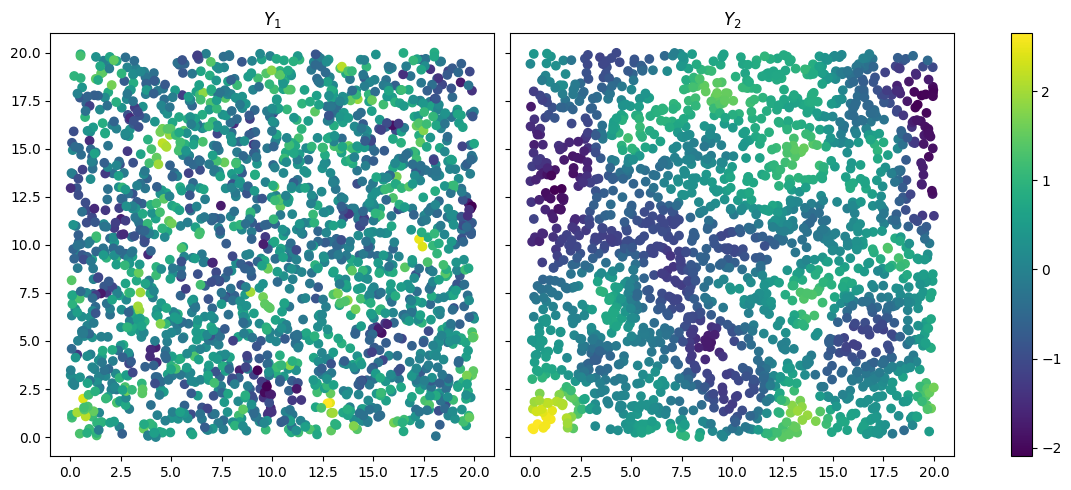

In [88]:
NestedCoKriging(X_1, X_2, Y_1, Y_2, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12).plot_obs()

In [89]:
times = []
rmses = []
porcentajes = np.arange(10, 110, 10)
num_iterations = 1

for porcentaje in porcentajes:
    execution_time = 0
    rmse = 0
    N = n_2 * porcentaje // 100
    for _ in range(num_iterations):
        start_time = time.time()
        
        coK_NN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, 
                             theta_1, theta_2, theta_12,
                             nu_1, nu_2, nu_12, rho_12)
        Y_pred = coK_NN.predict(X_test)
        
        end_time = time.time()
        
        execution_time += end_time - start_time
        rmse += root_mean_squared_error(Y_pred, Y_test)
    
    times.append(execution_time / num_iterations)
    rmses.append(rmse / num_iterations)

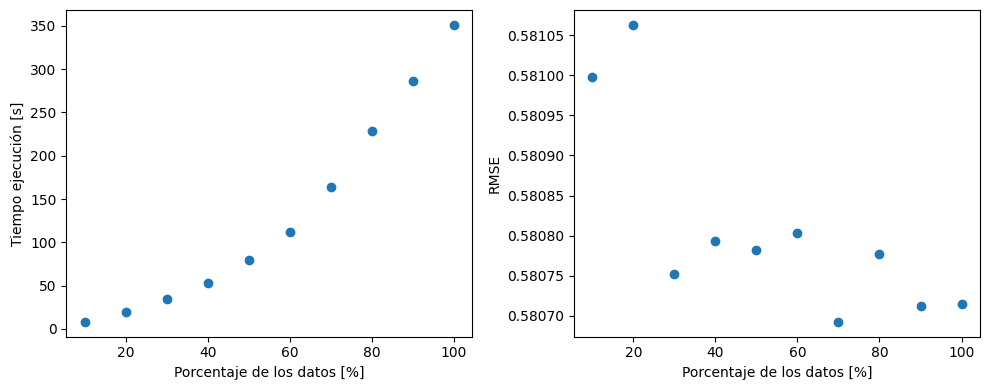

In [90]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.scatter(porcentajes, times)
ax1.set_xlabel('Porcentaje de los datos [%]'); ax1.set_ylabel('Tiempo ejecución [s]')

ax2.scatter(porcentajes, rmses)
ax2.set_xlabel('Porcentaje de los datos [%]'); ax2.set_ylabel('RMSE')

fig.tight_layout()

## CoKrigingNN vs NestedCoKriging

In [15]:
n_1 = 10_000 + 100
n_2 = 10_000
d = 2
sup = 20

nu_1 = 1/2
nu_2 = 1/2
theta_1 = 1
theta_2 = 0.7

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)

In [16]:
X_1, X_2, Y_1, Y_2 = gen_observations(d, n_1, n_2, sup, nu_1, theta_1, nu_2, theta_2, nu_12, theta_12, rho_12)

In [17]:
X_test, Y_test = X_1[:100], Y_1[:100]
X_1, Y_1 = X_1[100:], Y_1[100:]

In [25]:
RMSEs_coKNN = []
RMSEs_NcoK = []
times_coKNN = []
times_NcoK = []

ns = [100, 500, 1_000, 2_000, 3_000, 5_000, 6_000, 8_000, 10_000]
num_iterations = 1

for n in ns:
    RMSE_coKNN = np.zeros(2)
    RMSE_NcoK = np.zeros(2)
    time_coKNN = np.zeros(2)
    time_NcoK = np.zeros(2)

    for _ in range(num_iterations):
        indices = np.random.choice(n_2, size=n, replace=False)
        X_1_aux, Y_1_aux = X_1[indices], Y_1[indices]
        X_2_aux, Y_2_aux = X_2[indices], Y_2[indices]

# NESTED CO KRIGING
        for i, n_clusters in enumerate([n//50, n//100]):
            start_time = time.time()
            A_1 = gen_A(X_1_aux, n_clusters)
            A_2 = gen_A(X_2_aux, n_clusters)
            NcoK = NestedCoKriging(X_1_aux, X_2_aux, Y_1_aux, Y_2_aux, theta_1, 
                                   theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
            Y_pred = NcoK.predict(X_test, A_1, A_2)
            end_time = time.time()
            
            time_NcoK[i] += (end_time - start_time)
            RMSE_NcoK[i] += root_mean_squared_error(Y_pred, Y_test)
        
# CO KRIGING NN
        for i, porcentaje in enumerate([10, 80]):    
            start_time = time.time()
            N = n * porcentaje // 100
            coKNN = coKrigingNN(X_1_aux, X_2_aux, Y_1_aux, Y_2_aux,
                                N, theta_1, theta_2, theta_12,
                                nu_1, nu_2, nu_12, rho_12)
            Y_pred = coKNN.predict(X_test)
            end_time = time.time()
            
            time_coKNN[i] += (end_time - start_time)
            RMSE_coKNN[i] += root_mean_squared_error(Y_pred, Y_test)

    RMSEs_NcoK.append(RMSE_NcoK / num_iterations)    
    RMSEs_coKNN.append(RMSE_coKNN / num_iterations)  
    
    times_NcoK.append(time_NcoK / num_iterations)    
    times_coKNN.append(time_coKNN / num_iterations)    

RMSEs_NcoK = np.array(RMSEs_NcoK)
RMSEs_coKNN = np.array(RMSEs_coKNN)
times_NcoK = np.array(times_NcoK)
times_coKNN = np.array(times_coKNN)

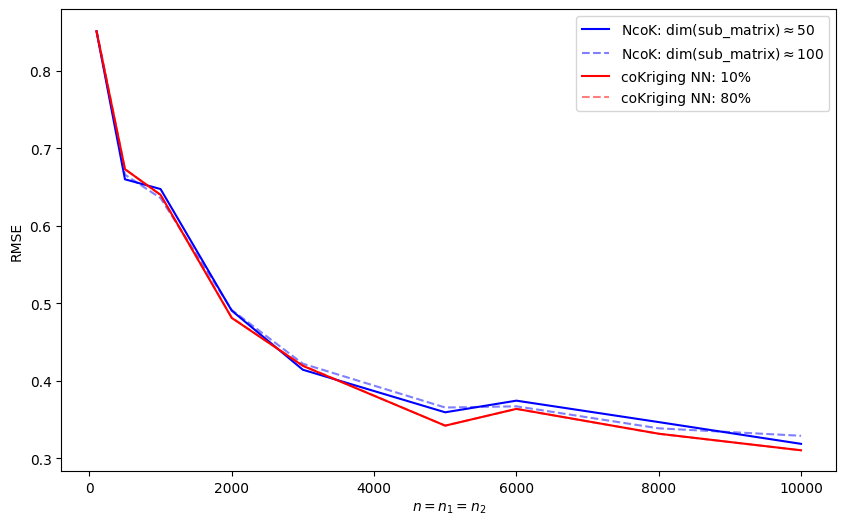

In [32]:
plt.figure(figsize=(10, 6))

plt.plot(ns, RMSEs_NcoK[:, 0], label=r'NcoK: dim(sub_matrix)$\approx$50', ls='-', c='b', alpha=1)
plt.plot(ns, RMSEs_NcoK[:, 1], label=r'NcoK: dim(sub_matrix)$\approx$100', ls='--', c='b', alpha=.5)
    
plt.plot(ns, RMSEs_coKNN[:, 0], label='coKriging NN: 10%', ls='-', c='r', alpha=1)
plt.plot(ns, RMSEs_coKNN[:, 1], label='coKriging NN: 80%', ls='--', c='r', alpha=.5)

plt.legend()
plt.xlabel(r'$n = n_1 = n_2$'); plt.ylabel('RMSE');

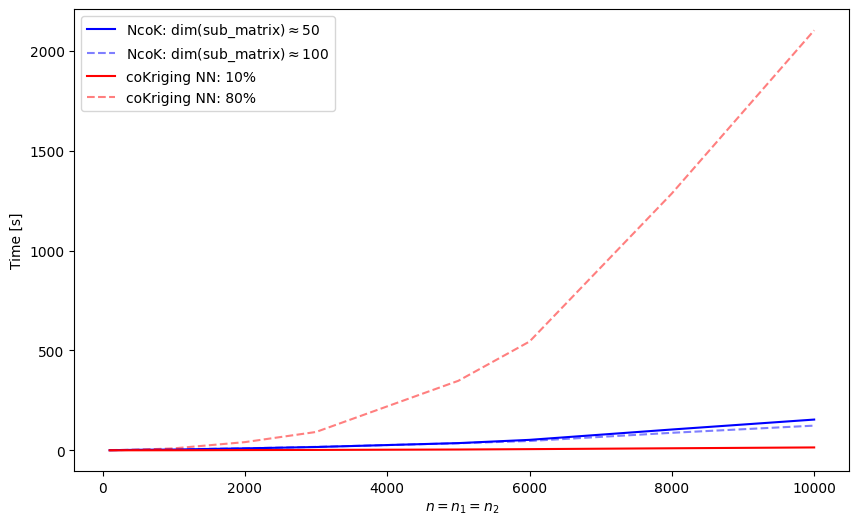

In [33]:
plt.figure(figsize=(10, 6))

plt.plot(ns, times_NcoK[:, 0], label=r'NcoK: dim(sub_matrix)$\approx$50', ls='-', c='b', alpha=1)
plt.plot(ns, times_NcoK[:, 1], label=r'NcoK: dim(sub_matrix)$\approx$100', ls='--', c='b', alpha=.5)
    
plt.plot(ns, times_coKNN[:, 0], label='coKriging NN: 10%', ls='-', c='r', alpha=1)
plt.plot(ns, times_coKNN[:, 1], label='coKriging NN: 80%', ls='--', c='r', alpha=.5)

plt.legend()
plt.xlabel(r'$n = n_1 = n_2$'); plt.ylabel('Time [s]');

## Análisis `n_clusters` 

In [45]:
times = []
rmses = []
num_iterations = 1

ns = [2_000, 3_000, 5_000, 8_000, 10_000]
dims_subsets = np.array([2, 50, 100, 500, 1_000])

for n in ns:
    RMSE_NcoK = np.zeros(len(dims_subsets))
    time_NcoK = np.zeros(len(dims_subsets))
    
    indices = np.random.choice(n_2, size=n, replace=False)
    X_1_aux, Y_1_aux = X_1[indices], Y_1[indices]
    X_2_aux, Y_2_aux = X_2[indices], Y_2[indices]

    for _ in range(num_iterations):
# NESTED CO KRIGING
        for i, n_clusters in enumerate(n//dims_subsets):
            start_time = time.time()
            A_1 = gen_A(X_1_aux, n_clusters)
            A_2 = gen_A(X_2_aux, n_clusters)
            NcoK = NestedCoKriging(X_1_aux, X_2_aux, Y_1_aux, Y_2_aux, theta_1, 
                                   theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
            Y_pred = NcoK.predict(X_test, A_1, A_2)
            end_time = time.time()
            
            time_NcoK[i] += (end_time - start_time)
            RMSE_NcoK[i] += root_mean_squared_error(Y_pred, Y_test)

    rmses.append(RMSE_NcoK / num_iterations)    
    times.append(time_NcoK / num_iterations)
    print(f'{n=} listo.')    

rmses = np.array(rmses)
times = np.array(times)       

n=2000 listo.
n=3000 listo.
n=5000 listo.
n=8000 listo.
n=10000 listo.


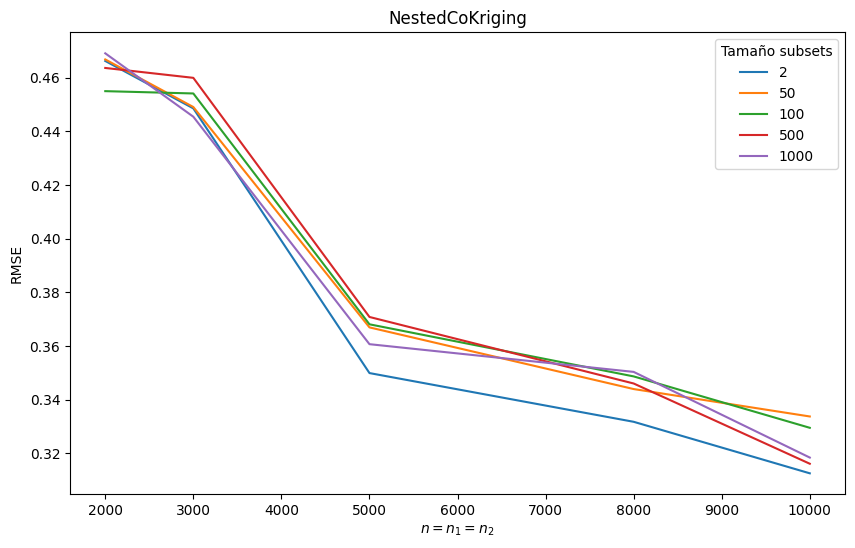

In [46]:
plt.figure(figsize=(10, 6))

for i, dim_subsets in enumerate(dims_subsets):
    plt.plot(ns, rmses[:, i], label=f'{dim_subsets}')

plt.legend(title='Tamaño subsets')
plt.title('NestedCoKriging')
plt.xlabel(r'$n = n_1 = n_2$'); plt.ylabel('RMSE');

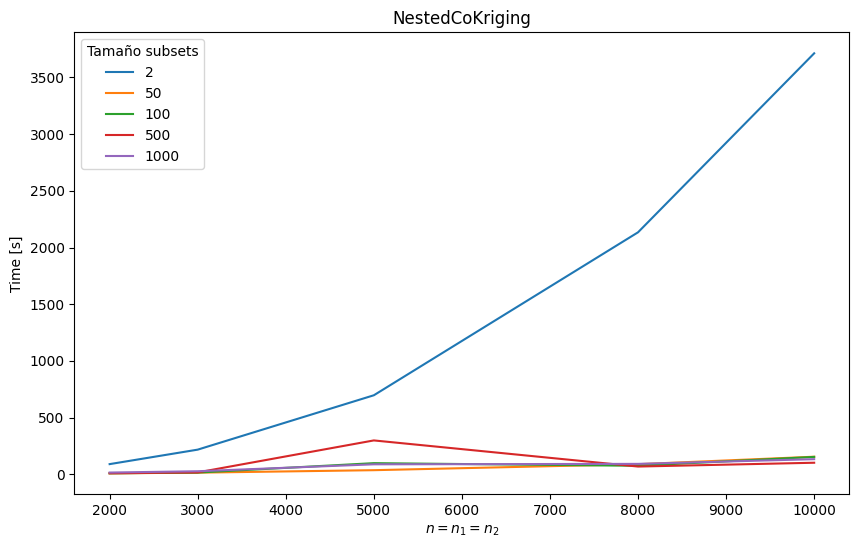

In [47]:
plt.figure(figsize=(10, 6))

for i, dim_subsets in enumerate(dims_subsets):
    plt.plot(ns, times[:, i], label=f'{dim_subsets}')

plt.legend(title='Tamaño subsets')
plt.title('NestedCoKriging')
plt.xlabel(r'$n = n_1 = n_2$'); plt.ylabel('Time [s]');

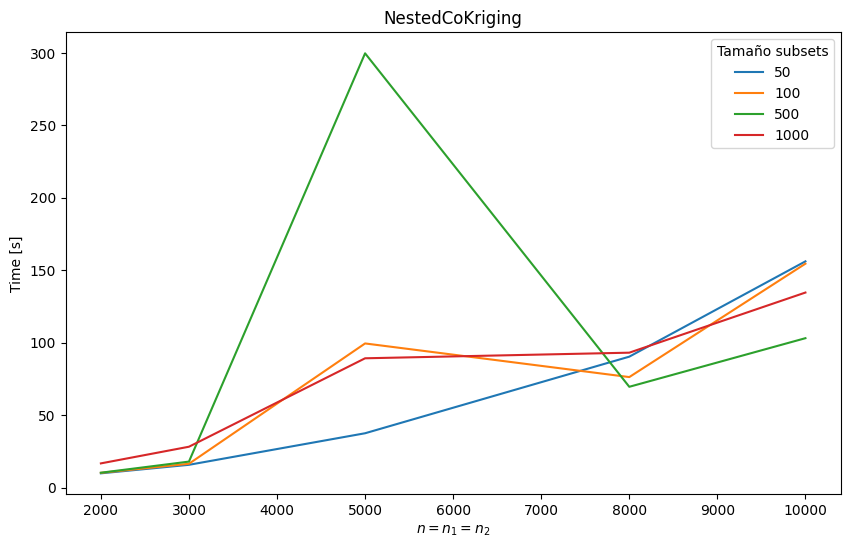

In [49]:
plt.figure(figsize=(10, 6))

for i, dim_subsets in enumerate(dims_subsets):
    if dim_subsets == 2:
        continue
    plt.plot(ns, times[:, i], label=f'{dim_subsets}')

plt.legend(title='Tamaño subsets')
plt.title('NestedCoKriging')
plt.xlabel(r'$n = n_1 = n_2$'); plt.ylabel('Time [s]');

## RMSE vs $\rho_{12}$

In [67]:
# Parameters fixed
d = 2
n_1 = 500 + 100
n_2 = 500
sup = 20

nu_1 = 3/2
nu_2 = 3/2
nu_12 = ( nu_1 + nu_2 ) / 2
theta_1 = 1

In [69]:
rhos_12 = []
RMSEs_K = []
RMSEs_NK = []
RMSEs_coK = []
RMSEs_coKNN = []
RMSEs_NcoK = []

thetas_2 = np.arange(0.05, 1.05, 0.05)
iter_n_clusters = n_2 // np.array([2, 250, 500])
num_iterations = 25

for theta_2 in thetas_2:
    theta_12 = theta_2
    rho_12 = theta_12
    rhos_12.append(rho_12)
    
    RMSE_K = 0
    RMSE_NK = np.zeros(len(iter_n_clusters))
    RMSE_coK = 0
    RMSE_NcoK = np.zeros(len(iter_n_clusters))
    RMSE_coKNN = np.zeros(2)
    
    for _ in range(num_iterations):
        X_1, X_2, Y_1, Y_2 = gen_observations(d, n_1, n_2, sup, nu_1, theta_1, nu_2, theta_2, nu_12, theta_12, rho_12)
        X_test, Y_test = X_1[:100], Y_1[:100]
        X_1, Y_1 = X_1[100:], Y_1[100:]
        
        # Kriging
        sigma = cov_matrix(matern_model(theta_1, nu_1), X_1, X_1)
        Y_K = kriging(X_test, X_1, Y_1, sigma, matern_model(theta_1, nu_1))
        RMSE_K += root_mean_squared_error(Y_K, Y_test)
          
        # CoKriging     
        sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)
        Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)
        RMSE_coK += root_mean_squared_error(Y_coK, Y_test)

        # CoKrigingNN
        for i, porcentaje in enumerate([10, 50]):
            N = n_2 * porcentaje//100
            coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2,
                                N, theta_1, theta_2, theta_12,
                                nu_1, nu_2, nu_12, rho_12)
            Y_coKNN = coKNN.predict(X_test)
            RMSE_coKNN[i] += root_mean_squared_error(Y_coKNN, Y_test)

        for i, n_clusters in enumerate(iter_n_clusters):        
            # Nested CoKriging
            A_1 = gen_A(X_1, n_clusters)
            A_2 = gen_A(X_2, n_clusters)
            NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
            Y_NcoK = NcoK.predict(X_test, A_1, A_2)
            RMSE_NcoK[i] += root_mean_squared_error(Y_NcoK, Y_test)
            
            # Nested Kriging
            NK = NestedKriging(X_1, Y_1, theta=theta_1, nu=nu_1)
            Y_NK = NK.predict(X_test, A_1)
            RMSE_NK[i] += root_mean_squared_error(Y_NK, Y_test)
            
    RMSEs_NcoK.append(RMSE_NcoK / num_iterations)
    RMSEs_K.append(RMSE_K / num_iterations)
    RMSEs_NK.append(RMSE_NK / num_iterations)
    RMSEs_coK.append(RMSE_coK / num_iterations)
    RMSEs_coKNN.append(RMSE_coKNN / num_iterations)

RMSEs_NK = np.array(RMSEs_NK)
RMSEs_NcoK = np.array(RMSEs_NcoK)
RMSEs_coKNN = np.array(RMSEs_coKNN)

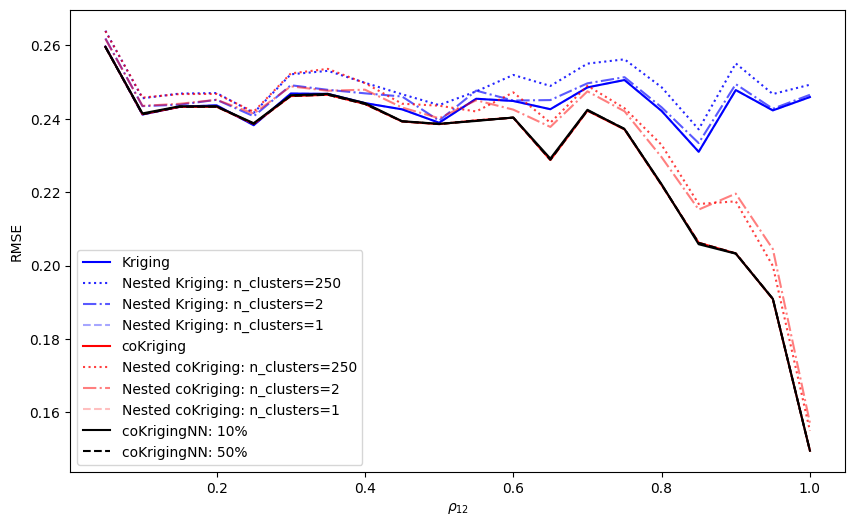

In [70]:
plt.figure(figsize=(10, 6))

plt.plot(rhos_12, RMSEs_K, label='Kriging', c='b')
plt.plot(rhos_12, RMSEs_NK[:, 0], label=f'Nested Kriging: n_clusters={iter_n_clusters[0]}', ls=':', c='b', alpha=.85)
plt.plot(rhos_12, RMSEs_NK[:, 1], label=f'Nested Kriging: n_clusters={iter_n_clusters[1]}', ls='-.', c='b', alpha=.65)
plt.plot(rhos_12, RMSEs_NK[:, 2], label=f'Nested Kriging: n_clusters={iter_n_clusters[2]}', ls='--', c='b', alpha=.35)
    
plt.plot(rhos_12, RMSEs_coK, label='coKriging', c='r')
plt.plot(rhos_12, RMSEs_NcoK[:, 0], label=f'Nested coKriging: n_clusters={iter_n_clusters[0]}', ls=':', c='r', alpha=.75)
plt.plot(rhos_12, RMSEs_NcoK[:, 1], label=f'Nested coKriging: n_clusters={iter_n_clusters[1]}', ls='-.', c='r', alpha=.5)
plt.plot(rhos_12, RMSEs_NcoK[:, 2], label=f'Nested coKriging: n_clusters={iter_n_clusters[2]}', ls='--', c='r', alpha=.25)

plt.plot(rhos_12, RMSEs_coKNN[:, 0], label='coKrigingNN: 10%', c='k')
plt.plot(rhos_12, RMSEs_coKNN[:, 1], label='coKrigingNN: 50%', c='k', ls='--')

plt.legend()
plt.xlabel(r'$\rho_{12}$'); plt.ylabel('RMSE');

## Cauchy model

$$\mathcal{C}_{\beta, a, \nu}(t) = (1+t^a/\beta)^{-\nu}$$
$\beta, \nu>0$, $a\in(0,1]$

Sabemos que $\mathcal{SG}_{0, \beta, \nu}(t) = \mathcal{C}_{\beta, 1, \nu}(t)$. Luego, por Teorema 1 en el caso Parsimonious $\mathcal{BSG}$: $\alpha_{12} = \frac{1}{2} \frac{\alpha_1 \alpha_2}{\alpha_1 + \alpha_2}$, $\beta_{12} = (\beta_1+\beta_2)/2$, $\nu_{12} = (\nu_1+\nu_2)/2$ si
$$|\rho| \leq \sqrt{\frac{A(\alpha_1,\beta_1, \nu_1)A(\alpha_2,\beta_2, \nu_2)}{A^2(\alpha_{12},\beta_{12}, \nu_{12})}}$$
entonces $\mathcal{BSG}$ es definida positiva. Donde


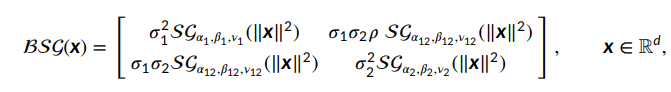

Si $\alpha_i=0$ (Cauchy), entonces $\alpha_{12} = 0 \textcolor{red}{???}$.

Note que $A(0, \beta, \nu) = \frac{\beta^\nu}{\Gamma(\nu)}$


Por ende, para la familia Cauchy con $a=1$, $\mathcal{C}_{\beta, 1, \nu}(t) = (1+t/\beta)^{-\nu}$
$\beta, \nu>0$ tenemos que el modelo es válido si, $\beta_{12} = (\beta_1+\beta_2)/2$, $\nu_{12} = (\nu_1+\nu_2)/2$ y
$$|\rho| \leq \sqrt{\frac{ \frac{\beta_1^{\nu_1}}{\Gamma(\nu_1)} \frac{\beta_2^{\nu_2}}{\Gamma(\nu_2)}}{ \frac{\beta_{12}^{2 \nu_{12}}}{\Gamma^2(\nu_{12})} }} = \frac{\Gamma(\nu_{12})}{\beta_{12}^{\nu_{12}}} \sqrt{\frac{\beta_1^{\nu_1}\beta_2^{\nu_2}}{\Gamma(\nu_1)\Gamma(\nu_2)}}$$


In [31]:
d = 2
n_1 = 2_500
n_2 = 2_000
sup = 2_000

theta_1 = 13.3
theta_2 = 6
nu_1 = 1.5
nu_2 = 0.5

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = ( theta_1 + theta_2 ) / 2

rho_12 = gamma(nu_12) / theta_12**nu_12 * np.sqrt(theta_1**nu_1 * theta_2**nu_2 / (gamma(nu_1) * gamma(nu_2))) - 1e-1
rho_12

0.8012375773593962

In [32]:
X_1 = np.random.uniform(0, sup, (n_1, d))
X_2 = np.random.uniform(0, sup, (n_2, d))

X_1, X_2, Y_1, Y_2 = gen_observations(X_1, X_2,
                                      cauchy_model(theta_1, nu_1),
                                      cauchy_model(theta_2, nu_2),
                                      cauchy_model(theta_12, nu_12),
                                      rho_12)

In [33]:
X_1, X_test, Y_1, Y_test = train_test_split(X_1, Y_1, test_size=0.2)

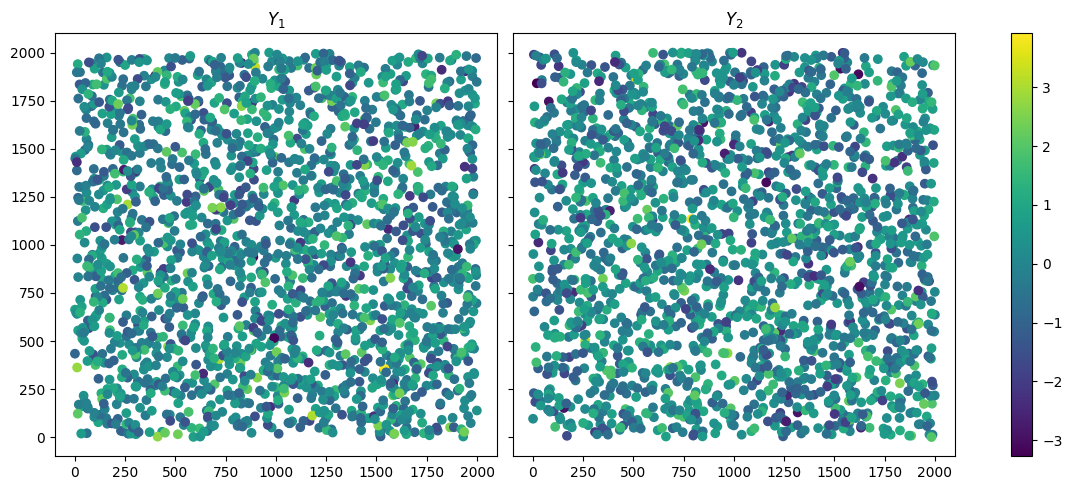

In [34]:
NestedCoKriging(X_1, X_2, Y_1, Y_2, cauchy_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12).plot_obs()

In [35]:
times = []
rmses = []
porcentajes = np.arange(10, 90, 10)
num_iterations = 1

for porcentaje in porcentajes:
    execution_time = 0
    rmse = 0
    N = n_2 * porcentaje // 100
    for _ in range(num_iterations):
        start_time = time.time()
        
        coK_NN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, cauchy_model,
                             theta_1, theta_2, theta_12,
                             nu_1, nu_2, nu_12, rho_12)
        Y_pred = coK_NN.predict(X_test)
        
        end_time = time.time()
        
        execution_time += end_time - start_time
        rmse += root_mean_squared_error(Y_pred, Y_test)
    print(f'{porcentaje}% listo :)')
    
    times.append(execution_time / num_iterations)
    rmses.append(rmse / num_iterations)

10% listo :)
20% listo :)
30% listo :)
40% listo :)
50% listo :)
60% listo :)
70% listo :)
80% listo :)


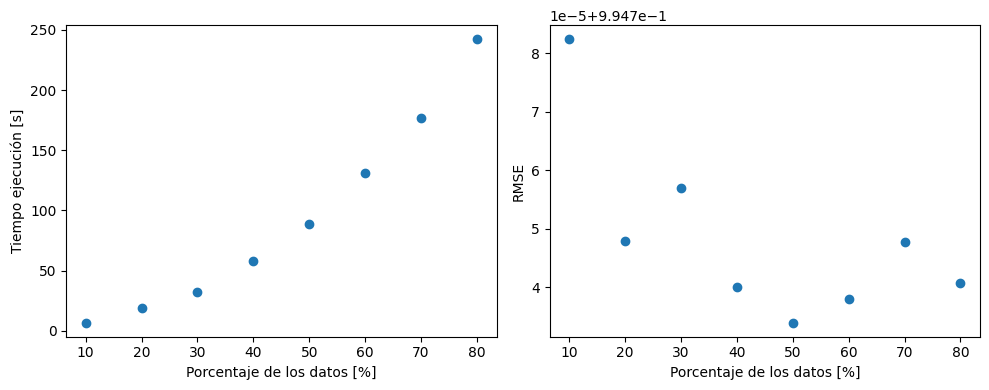

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.scatter(porcentajes, times)
ax1.set_xlabel('Porcentaje de los datos [%]'); ax1.set_ylabel('Tiempo ejecución [s]')

ax2.scatter(porcentajes, rmses)
ax2.set_xlabel('Porcentaje de los datos [%]'); ax2.set_ylabel('RMSE')

fig.tight_layout()

## NestedCoKriging vs CoKrigingNN

In [21]:
n_1 = 5_000 + 100
n_2 = 5_000
d = 2
sup = 2_000

theta_1 = 13.3
theta_2 = 6
nu_1 = 1.5
nu_2 = 0.5

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = ( theta_1 + theta_2 ) / 2

rho_12 = gamma(nu_12) / theta_12**nu_12 * np.sqrt(theta_1**nu_1 * theta_2**nu_2 / (gamma(nu_1) * gamma(nu_2))) 
rho_12 = -np.floor(rho_12*1e2)/1e2 # Truncamos a 2 decimales
rho_12

-0.9

In [22]:
X_1 = np.random.uniform(0, sup, (n_1, d))
X_2 = np.random.uniform(0, sup, (n_2, d))

X_1, X_2, Y_1, Y_2 = gen_observations(X_1, X_2,
                                      cauchy_model(theta_1, nu_1),
                                      cauchy_model(theta_2, nu_2),
                                      cauchy_model(theta_12, nu_12),
                                      rho_12)

In [23]:
X_test, Y_test = X_1[:100], Y_1[:100]
X_1, Y_1 = X_1[100:], Y_1[100:]

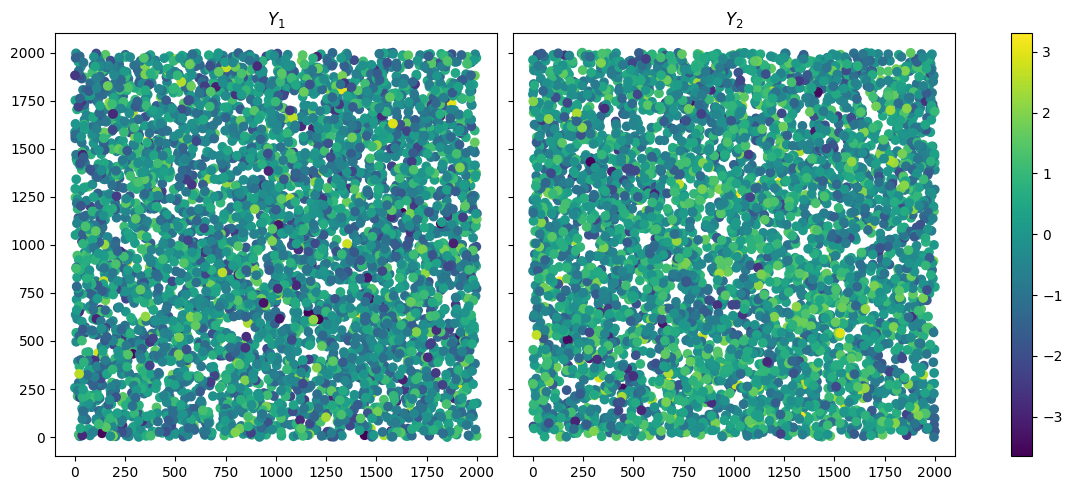

In [24]:
NestedCoKriging(X_1, X_2, Y_1, Y_2, cauchy_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12).plot_obs()

In [25]:
RMSEs_coKNN = []
RMSEs_NcoK = []
times_coKNN = []
times_NcoK = []

ns = [100, 500, 1_000, 2_000, 3_000, 4_000, 5_000]
num_iterations = 5

for n in ns:
    RMSE_coKNN = np.zeros(2)
    RMSE_NcoK = np.zeros(2)
    time_coKNN = np.zeros(2)
    time_NcoK = np.zeros(2)

    for _ in range(num_iterations):
        indices = np.random.choice(n_2, size=n, replace=False)
        X_1_aux, Y_1_aux = X_1[indices], Y_1[indices]
        X_2_aux, Y_2_aux = X_2[indices], Y_2[indices]

# NESTED CO KRIGING
        for i, n_clusters in enumerate([n//2, n//50]):
            start_time = time.time()
            A_1 = gen_A(X_1_aux, n_clusters)
            A_2 = gen_A(X_2_aux, n_clusters)
            NcoK = NestedCoKriging(X_1_aux, X_2_aux, Y_1_aux, Y_2_aux, cauchy_model, 
                                   theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
            Y_pred = NcoK.predict(X_test, A_1, A_2)
            end_time = time.time()
            
            time_NcoK[i] += (end_time - start_time)
            RMSE_NcoK[i] += root_mean_squared_error(Y_pred, Y_test)
        
# CO KRIGING NN
        for i, porcentaje in enumerate([5, 30]):    
            start_time = time.time()
            N = n * porcentaje // 100
            coKNN = coKrigingNN(X_1_aux, X_2_aux, Y_1_aux, Y_2_aux,
                                N, cauchy_model, theta_1, theta_2, 
                                theta_12, nu_1, nu_2, nu_12, rho_12)
            Y_pred = coKNN.predict(X_test)
            end_time = time.time()
            
            time_coKNN[i] += (end_time - start_time)
            RMSE_coKNN[i] += root_mean_squared_error(Y_pred, Y_test)
    print(f'{n=} listo :)')
    RMSEs_NcoK.append(RMSE_NcoK / num_iterations)    
    RMSEs_coKNN.append(RMSE_coKNN / num_iterations)  
    
    times_NcoK.append(time_NcoK / num_iterations)    
    times_coKNN.append(time_coKNN / num_iterations)    

RMSEs_NcoK = np.array(RMSEs_NcoK)
RMSEs_coKNN = np.array(RMSEs_coKNN)
times_NcoK = np.array(times_NcoK)
times_coKNN = np.array(times_coKNN)

n=100 listo :)
n=500 listo :)
n=1000 listo :)
n=2000 listo :)
n=3000 listo :)
n=4000 listo :)
n=5000 listo :)


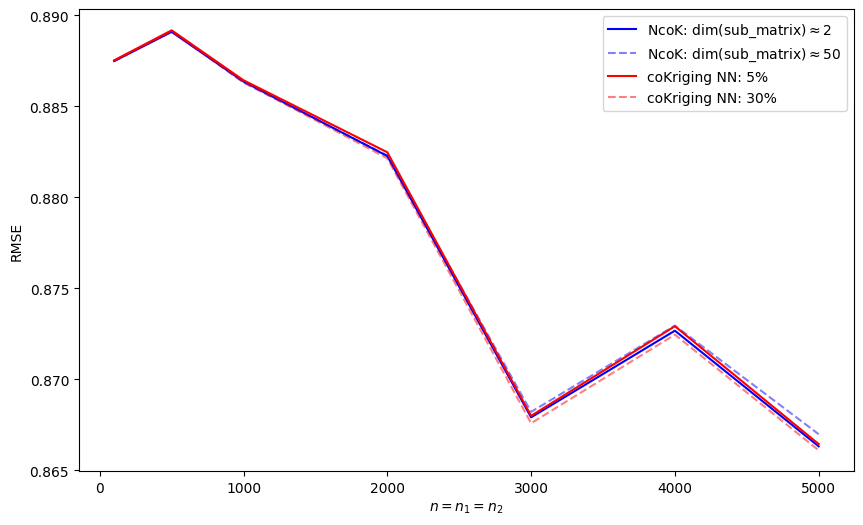

In [26]:
plt.figure(figsize=(10, 6))

plt.plot(ns, RMSEs_NcoK[:, 0], label=r'NcoK: dim(sub_matrix)$\approx$2', ls='-', c='b', alpha=1)
plt.plot(ns, RMSEs_NcoK[:, 1], label=r'NcoK: dim(sub_matrix)$\approx$50', ls='--', c='b', alpha=.5)
    
plt.plot(ns, RMSEs_coKNN[:, 0], label='coKriging NN: 5%', ls='-', c='r', alpha=1)
plt.plot(ns, RMSEs_coKNN[:, 1], label='coKriging NN: 30%', ls='--', c='r', alpha=.5)

plt.legend()
plt.xlabel(r'$n = n_1 = n_2$'); plt.ylabel('RMSE');

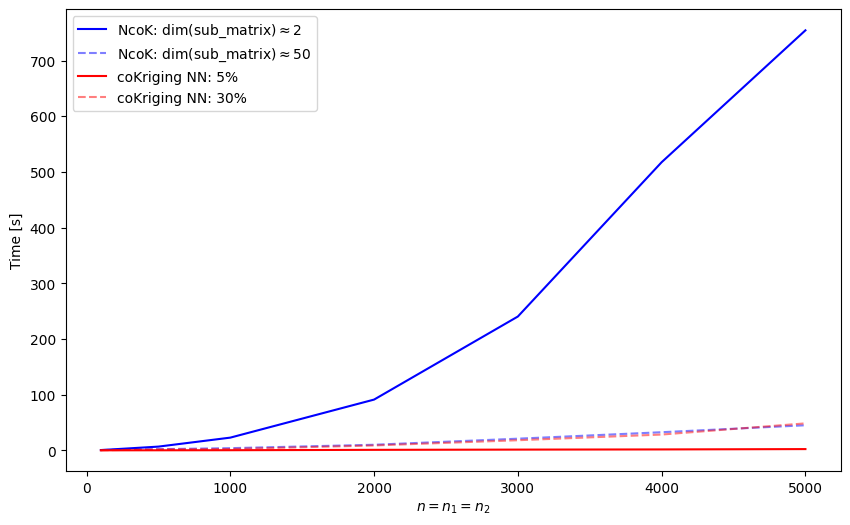

In [27]:
plt.figure(figsize=(10, 6))

plt.plot(ns, times_NcoK[:, 0], label=r'NcoK: dim(sub_matrix)$\approx$2', ls='-', c='b', alpha=1)
plt.plot(ns, times_NcoK[:, 1], label=r'NcoK: dim(sub_matrix)$\approx$50', ls='--', c='b', alpha=.5)
    
plt.plot(ns, times_coKNN[:, 0], label='coKriging NN: 5%', ls='-', c='r', alpha=1)
plt.plot(ns, times_coKNN[:, 1], label='coKriging NN: 30%', ls='--', c='r', alpha=.5)

plt.legend()
plt.xlabel(r'$n = n_1 = n_2$'); plt.ylabel('Time [s]');

### Ahora considerando para todo $n$, $N=100$ o $N=50$ observaciones cercanas.

In [28]:
RMSEs_coKNN = []
RMSEs_NcoK = []
times_coKNN = []
times_NcoK = []

ns = [100, 500, 1_000, 2_000, 3_000, 4_000, 5_000]
num_iterations = 5

for n in ns:
    RMSE_coKNN = np.zeros(2)
    RMSE_NcoK = np.zeros(2)
    time_coKNN = np.zeros(2)
    time_NcoK = np.zeros(2)

    for _ in range(num_iterations):
        indices = np.random.choice(n_2, size=n, replace=False)
        X_1_aux, Y_1_aux = X_1[indices], Y_1[indices]
        X_2_aux, Y_2_aux = X_2[indices], Y_2[indices]

# NESTED CO KRIGING
        for i, n_clusters in enumerate([n//2, n//50]):
            start_time = time.time()
            A_1 = gen_A(X_1_aux, n_clusters)
            A_2 = gen_A(X_2_aux, n_clusters)
            NcoK = NestedCoKriging(X_1_aux, X_2_aux, Y_1_aux, Y_2_aux, cauchy_model, 
                                   theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
            Y_pred = NcoK.predict(X_test, A_1, A_2)
            end_time = time.time()
            
            time_NcoK[i] += (end_time - start_time)
            RMSE_NcoK[i] += root_mean_squared_error(Y_pred, Y_test)
        
# CO KRIGING NN
        for i, N in enumerate([50, 100]):    
            start_time = time.time()
            coKNN = coKrigingNN(X_1_aux, X_2_aux, Y_1_aux, Y_2_aux,
                                N, cauchy_model, theta_1, theta_2, 
                                theta_12, nu_1, nu_2, nu_12, rho_12)
            Y_pred = coKNN.predict(X_test)
            end_time = time.time()
            
            time_coKNN[i] += (end_time - start_time)
            RMSE_coKNN[i] += root_mean_squared_error(Y_pred, Y_test)
    print(f'{n=} listo :)')
    RMSEs_NcoK.append(RMSE_NcoK / num_iterations)    
    RMSEs_coKNN.append(RMSE_coKNN / num_iterations)  
    
    times_NcoK.append(time_NcoK / num_iterations)    
    times_coKNN.append(time_coKNN / num_iterations)    

RMSEs_NcoK = np.array(RMSEs_NcoK)
RMSEs_coKNN = np.array(RMSEs_coKNN)
times_NcoK = np.array(times_NcoK)
times_coKNN = np.array(times_coKNN)

n=100 listo :)
n=500 listo :)
n=1000 listo :)
n=2000 listo :)
n=3000 listo :)
n=4000 listo :)
n=5000 listo :)


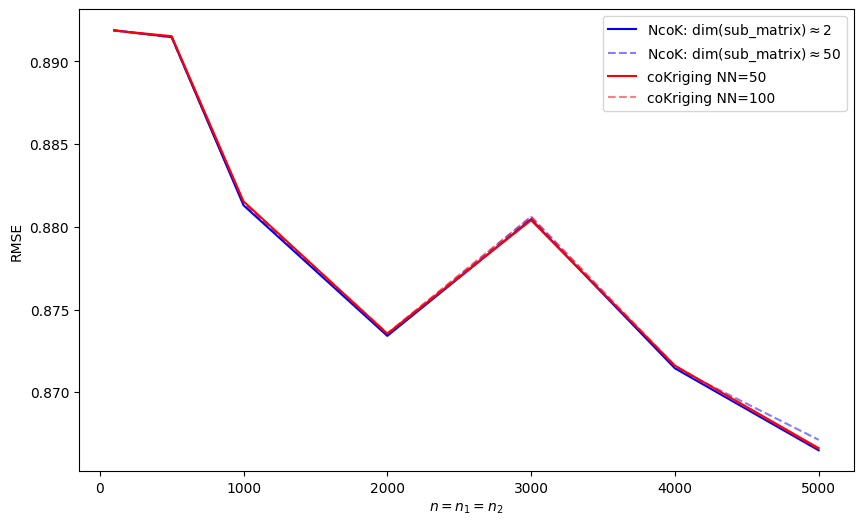

In [29]:
plt.figure(figsize=(10, 6))

plt.plot(ns, RMSEs_NcoK[:, 0], label=r'NcoK: dim(sub_matrix)$\approx$2', ls='-', c='b', alpha=1)
plt.plot(ns, RMSEs_NcoK[:, 1], label=r'NcoK: dim(sub_matrix)$\approx$50', ls='--', c='b', alpha=.5)
    
plt.plot(ns, RMSEs_coKNN[:, 0], label='coKriging NN=50', ls='-', c='r', alpha=1)
plt.plot(ns, RMSEs_coKNN[:, 1], label='coKriging NN=100', ls='--', c='r', alpha=.5)

plt.legend()
plt.xlabel(r'$n = n_1 = n_2$'); plt.ylabel('RMSE');

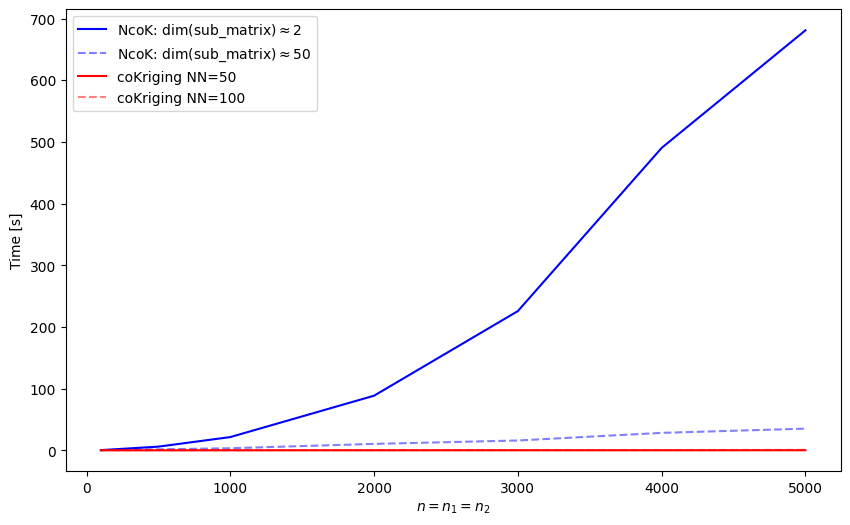

In [30]:
plt.figure(figsize=(10, 6))

plt.plot(ns, times_NcoK[:, 0], label=r'NcoK: dim(sub_matrix)$\approx$2', ls='-', c='b', alpha=1)
plt.plot(ns, times_NcoK[:, 1], label=r'NcoK: dim(sub_matrix)$\approx$50', ls='--', c='b', alpha=.5)
    
plt.plot(ns, times_coKNN[:, 0], label='coKriging NN=50', ls='-', c='r', alpha=1)
plt.plot(ns, times_coKNN[:, 1], label='coKriging NN=100', ls='--', c='r', alpha=.5)

plt.legend()
plt.xlabel(r'$n = n_1 = n_2$'); plt.ylabel('Time [s]');